# 1. Data preprocessing

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re

In [2]:
# Read data
df1 = pd.read_json('domain1_train_data.json', lines=True)
df2 = pd.read_json('domain2_train_data.json', lines=True)

# Train dev split
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=42)
df2_train, df2_dev = train_test_split(df2, stratify=df2['label'], random_state=42)

# Join data in both domains for trating them jointly (Augmentation)
dev_set = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)
df3_train = pd.concat([df1_train, df2_train]).reset_index(drop=True)

# Train and dev sets
x_tr, y_train = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in df3_train['text']], df3_train['label']
x_dev, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in dev_set['text']], dev_set['label']

# 2. Encoding

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Cvec encoding
Cvec = CountVectorizer()
x_train_c = Cvec.fit_transform(x_tr)
x_dev_c = Cvec.transform(x_dev)

# # Tvec encoding
# Tvec = TfidfVectorizer()
# x_train_t = Tvec.fit_transform(x_tr)
# x_dev_t = Tvec.transform(x_dev)

# 3 DL Models (Embeding model)

In [4]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
device = 'cpu'
torch.manual_seed(42)

In [5]:
# Dataset to TensorDataset
train_DS = TensorDataset(torch.from_numpy(x_train_c.todense()).float(), torch.from_numpy(np.array(y_train)).float().reshape(-1,1))
dev_DS = TensorDataset(torch.from_numpy(x_dev_c.todense()).float(), torch.from_numpy(np.array(y_dev)).float().reshape(-1,1))
# TensorDataset to dataloader
x_tr_dl = DataLoader(train_DS,batch_size=100, shuffle=True)
x_dev_dl = DataLoader(dev_DS,batch_size=100, shuffle=True)

In [6]:
from torch import nn
class BowNetwork(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        self.first_layer = nn.Linear(vocab_size, hidden_dim) 
        nn.init.uniform_(self.first_layer.weight)
        self.second_layer = nn.Linear(hidden_dim, hidden_dim)
        self.third_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.first_layer(x)) 
        x = torch.relu(self.second_layer(x)) 
        logits = self.third_layer(x)
        return logits

In [7]:
vocab_size = x_train_c.shape[1]
bow_model = BowNetwork(vocab_size, 100).to(device)
print(bow_model)

BowNetwork(
  (first_layer): Linear(in_features=69661, out_features=100, bias=True)
  (second_layer): Linear(in_features=100, out_features=100, bias=True)
  (third_layer): Linear(in_features=100, out_features=1, bias=True)
)


In [8]:
from torch.optim.lr_scheduler import CosineAnnealingLR
# Loss fn
class_weights_domain2 = torch.FloatTensor(df2_train['label'].shape/df2_train['label'].value_counts()).float().to(device)
def get_batch_weights(labels, class_weights_domain2):
    return class_weights_domain2[labels.long()].unsqueeze(1)
# Optimizer
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=5e-5,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [9]:
from tqdm import tqdm
# Train
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, acc, total = 0, 0, 0
    for X, y in tqdm(dataloader):
        pred = model(X)                         # Forward pass
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights_domain2[1]).to(device)
        loss = loss_fn(pred, y)                 # Compute loss 
        loss.backward()                         # Backpropagation
        optimizer.step()                        # Update parameters
        scheduler.step()                        # Update optimizer
        optimizer.zero_grad()                   # Reset gradient
    
        # Metrics
        train_loss += loss.item()
        total += len(y)
        result = (pred>0.5).float()
        acc += (result == y).sum().item()
        
    # General metrics
    train_loss /= total
    acc /= size
    return train_loss, acc

In [10]:
# Test
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, acc, total = 0, 0, 0
    with torch.no_grad():       # Specify no gradient
        for X, y in dataloader:
            pred = model(X)                                     # Forward pass
            loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights_domain2[1]).to(device)
            test_loss += loss_fn(pred, y).item()  # Compute loss     
            
            # Metrics
            result = (pred>0.5).float()             # Results to binary
            acc += (result == y).sum().item()       # Accuracy
            total += len(y)                         # Total observations
            
    # General metrics
    test_loss /= total
    acc /= size
    return test_loss, acc

In [11]:
from tqdm import tqdm, tqdm_notebook # show progress bar

# Epochs
epochs = 100
train_loss, valid_loss = [], []
print("Training BOW feedforward network model!")
for t in range(epochs):
    tl, train_acc = train(x_tr_dl, bow_model, optimizer)
    vl, valid_acc = test(x_dev_dl, bow_model)
    # Losses to dict
    train_loss.append(tl)
    valid_loss.append(vl)
    # Print results
    tqdm.write(
        f'epoch #{t}\ttrain_acc: {train_acc:.3f}\tvalid_acc: {valid_acc:.3f}',
    )

Training BOW feedforward network model!


100%|██████████| 135/135 [00:06<00:00, 20.20it/s]


epoch #0	train_acc: 0.424	valid_acc: 0.577


100%|██████████| 135/135 [00:06<00:00, 22.12it/s]


epoch #1	train_acc: 0.599	valid_acc: 0.642


100%|██████████| 135/135 [00:07<00:00, 18.37it/s]


epoch #2	train_acc: 0.608	valid_acc: 0.647


100%|██████████| 135/135 [00:06<00:00, 21.26it/s]


epoch #3	train_acc: 0.626	valid_acc: 0.614


100%|██████████| 135/135 [00:06<00:00, 21.09it/s]


epoch #4	train_acc: 0.634	valid_acc: 0.674


100%|██████████| 135/135 [00:06<00:00, 21.42it/s]


epoch #5	train_acc: 0.647	valid_acc: 0.681


100%|██████████| 135/135 [00:06<00:00, 21.64it/s]


epoch #6	train_acc: 0.652	valid_acc: 0.684


100%|██████████| 135/135 [00:06<00:00, 21.19it/s]


epoch #7	train_acc: 0.660	valid_acc: 0.672


100%|██████████| 135/135 [00:06<00:00, 21.48it/s]


epoch #8	train_acc: 0.666	valid_acc: 0.660


100%|██████████| 135/135 [00:06<00:00, 20.86it/s]


epoch #9	train_acc: 0.671	valid_acc: 0.661


100%|██████████| 135/135 [00:06<00:00, 21.61it/s]


epoch #10	train_acc: 0.679	valid_acc: 0.660


100%|██████████| 135/135 [00:06<00:00, 21.21it/s]


epoch #11	train_acc: 0.683	valid_acc: 0.715


100%|██████████| 135/135 [00:06<00:00, 21.13it/s]


epoch #12	train_acc: 0.692	valid_acc: 0.727


100%|██████████| 135/135 [00:06<00:00, 21.17it/s]


epoch #13	train_acc: 0.696	valid_acc: 0.719


100%|██████████| 135/135 [00:06<00:00, 20.93it/s]


epoch #14	train_acc: 0.699	valid_acc: 0.641


100%|██████████| 135/135 [00:06<00:00, 20.29it/s]


epoch #15	train_acc: 0.700	valid_acc: 0.642


100%|██████████| 135/135 [00:06<00:00, 22.11it/s]


epoch #16	train_acc: 0.708	valid_acc: 0.740


100%|██████████| 135/135 [00:06<00:00, 22.04it/s]


epoch #17	train_acc: 0.711	valid_acc: 0.737


100%|██████████| 135/135 [00:05<00:00, 22.53it/s]


epoch #18	train_acc: 0.709	valid_acc: 0.695


100%|██████████| 135/135 [00:06<00:00, 21.88it/s]


epoch #19	train_acc: 0.720	valid_acc: 0.714


100%|██████████| 135/135 [00:06<00:00, 22.36it/s]


epoch #20	train_acc: 0.717	valid_acc: 0.690


100%|██████████| 135/135 [00:06<00:00, 22.09it/s]


epoch #21	train_acc: 0.726	valid_acc: 0.722


100%|██████████| 135/135 [00:06<00:00, 22.00it/s]


epoch #22	train_acc: 0.724	valid_acc: 0.727


100%|██████████| 135/135 [00:06<00:00, 22.44it/s]


epoch #23	train_acc: 0.730	valid_acc: 0.735


100%|██████████| 135/135 [00:06<00:00, 22.34it/s]


epoch #24	train_acc: 0.732	valid_acc: 0.660


100%|██████████| 135/135 [00:06<00:00, 22.15it/s]


epoch #25	train_acc: 0.735	valid_acc: 0.660


100%|██████████| 135/135 [00:06<00:00, 22.16it/s]


epoch #26	train_acc: 0.739	valid_acc: 0.701


100%|██████████| 135/135 [00:07<00:00, 19.00it/s]


epoch #27	train_acc: 0.742	valid_acc: 0.749


100%|██████████| 135/135 [00:06<00:00, 19.52it/s]


epoch #28	train_acc: 0.747	valid_acc: 0.732


100%|██████████| 135/135 [00:06<00:00, 19.42it/s]


epoch #29	train_acc: 0.753	valid_acc: 0.724


100%|██████████| 135/135 [00:06<00:00, 20.11it/s]


epoch #30	train_acc: 0.752	valid_acc: 0.683


100%|██████████| 135/135 [00:06<00:00, 20.80it/s]


epoch #31	train_acc: 0.755	valid_acc: 0.731


100%|██████████| 135/135 [00:07<00:00, 18.73it/s]


epoch #32	train_acc: 0.757	valid_acc: 0.710


100%|██████████| 135/135 [00:07<00:00, 17.03it/s]


epoch #33	train_acc: 0.760	valid_acc: 0.749


100%|██████████| 135/135 [00:06<00:00, 20.58it/s]


epoch #34	train_acc: 0.764	valid_acc: 0.744


100%|██████████| 135/135 [00:06<00:00, 20.89it/s]


epoch #35	train_acc: 0.768	valid_acc: 0.665


100%|██████████| 135/135 [00:07<00:00, 18.66it/s]


epoch #36	train_acc: 0.768	valid_acc: 0.743


100%|██████████| 135/135 [00:06<00:00, 19.46it/s]


epoch #37	train_acc: 0.771	valid_acc: 0.770


100%|██████████| 135/135 [00:06<00:00, 20.61it/s]


epoch #38	train_acc: 0.774	valid_acc: 0.731


100%|██████████| 135/135 [00:06<00:00, 20.19it/s]


epoch #39	train_acc: 0.777	valid_acc: 0.737


100%|██████████| 135/135 [00:06<00:00, 20.47it/s]


epoch #40	train_acc: 0.779	valid_acc: 0.699


100%|██████████| 135/135 [00:07<00:00, 19.10it/s]


epoch #41	train_acc: 0.779	valid_acc: 0.699


100%|██████████| 135/135 [00:07<00:00, 18.57it/s]


epoch #42	train_acc: 0.785	valid_acc: 0.738


100%|██████████| 135/135 [00:07<00:00, 18.29it/s]


epoch #43	train_acc: 0.784	valid_acc: 0.757


100%|██████████| 135/135 [00:07<00:00, 19.12it/s]


epoch #44	train_acc: 0.787	valid_acc: 0.768


100%|██████████| 135/135 [00:07<00:00, 19.18it/s]


epoch #45	train_acc: 0.792	valid_acc: 0.724


100%|██████████| 135/135 [00:07<00:00, 18.87it/s]


epoch #46	train_acc: 0.797	valid_acc: 0.752


100%|██████████| 135/135 [00:09<00:00, 14.34it/s]


epoch #47	train_acc: 0.799	valid_acc: 0.765


100%|██████████| 135/135 [00:08<00:00, 15.38it/s]


epoch #48	train_acc: 0.799	valid_acc: 0.747


100%|██████████| 135/135 [00:07<00:00, 17.85it/s]


epoch #49	train_acc: 0.803	valid_acc: 0.748


100%|██████████| 135/135 [00:07<00:00, 18.10it/s]


epoch #50	train_acc: 0.804	valid_acc: 0.769


100%|██████████| 135/135 [00:07<00:00, 18.15it/s]


epoch #51	train_acc: 0.804	valid_acc: 0.744


100%|██████████| 135/135 [00:07<00:00, 18.78it/s]


epoch #52	train_acc: 0.807	valid_acc: 0.757


100%|██████████| 135/135 [00:07<00:00, 17.17it/s]


epoch #53	train_acc: 0.808	valid_acc: 0.770


100%|██████████| 135/135 [00:08<00:00, 15.96it/s]


epoch #54	train_acc: 0.813	valid_acc: 0.764


100%|██████████| 135/135 [00:07<00:00, 18.01it/s]


epoch #55	train_acc: 0.817	valid_acc: 0.762


100%|██████████| 135/135 [00:07<00:00, 19.16it/s]


epoch #56	train_acc: 0.817	valid_acc: 0.740


100%|██████████| 135/135 [00:09<00:00, 14.78it/s]


epoch #57	train_acc: 0.819	valid_acc: 0.749


100%|██████████| 135/135 [00:07<00:00, 17.01it/s]


epoch #58	train_acc: 0.821	valid_acc: 0.774


100%|██████████| 135/135 [00:08<00:00, 15.93it/s]


epoch #59	train_acc: 0.822	valid_acc: 0.734


100%|██████████| 135/135 [00:08<00:00, 15.73it/s]


epoch #60	train_acc: 0.827	valid_acc: 0.784


100%|██████████| 135/135 [00:08<00:00, 16.81it/s]


epoch #61	train_acc: 0.831	valid_acc: 0.784


100%|██████████| 135/135 [00:07<00:00, 17.43it/s]


epoch #62	train_acc: 0.833	valid_acc: 0.758


100%|██████████| 135/135 [00:07<00:00, 18.94it/s]


epoch #63	train_acc: 0.834	valid_acc: 0.774


100%|██████████| 135/135 [00:07<00:00, 18.56it/s]


epoch #64	train_acc: 0.837	valid_acc: 0.773


100%|██████████| 135/135 [00:07<00:00, 18.80it/s]


epoch #65	train_acc: 0.840	valid_acc: 0.762


100%|██████████| 135/135 [00:07<00:00, 19.20it/s]


epoch #66	train_acc: 0.841	valid_acc: 0.785


100%|██████████| 135/135 [00:07<00:00, 18.73it/s]


epoch #67	train_acc: 0.842	valid_acc: 0.768


100%|██████████| 135/135 [00:07<00:00, 19.21it/s]


epoch #68	train_acc: 0.845	valid_acc: 0.777


100%|██████████| 135/135 [00:07<00:00, 19.04it/s]


epoch #69	train_acc: 0.851	valid_acc: 0.786


100%|██████████| 135/135 [00:07<00:00, 19.04it/s]


epoch #70	train_acc: 0.853	valid_acc: 0.779


100%|██████████| 135/135 [00:07<00:00, 18.90it/s]


epoch #71	train_acc: 0.854	valid_acc: 0.785


100%|██████████| 135/135 [00:07<00:00, 18.67it/s]


epoch #72	train_acc: 0.858	valid_acc: 0.778


100%|██████████| 135/135 [00:07<00:00, 17.14it/s]


epoch #73	train_acc: 0.859	valid_acc: 0.763


100%|██████████| 135/135 [00:07<00:00, 17.23it/s]


epoch #74	train_acc: 0.862	valid_acc: 0.783


100%|██████████| 135/135 [00:07<00:00, 17.33it/s]


epoch #75	train_acc: 0.865	valid_acc: 0.778


100%|██████████| 135/135 [00:07<00:00, 18.59it/s]


epoch #76	train_acc: 0.867	valid_acc: 0.775


100%|██████████| 135/135 [00:07<00:00, 18.56it/s]


epoch #77	train_acc: 0.869	valid_acc: 0.785


100%|██████████| 135/135 [00:08<00:00, 16.74it/s]


epoch #78	train_acc: 0.872	valid_acc: 0.792


100%|██████████| 135/135 [00:07<00:00, 19.17it/s]


epoch #79	train_acc: 0.874	valid_acc: 0.784


100%|██████████| 135/135 [00:06<00:00, 20.08it/s]


epoch #80	train_acc: 0.878	valid_acc: 0.785


100%|██████████| 135/135 [00:06<00:00, 19.77it/s]


epoch #81	train_acc: 0.880	valid_acc: 0.773


100%|██████████| 135/135 [00:08<00:00, 15.87it/s]


epoch #82	train_acc: 0.880	valid_acc: 0.796


100%|██████████| 135/135 [00:07<00:00, 18.81it/s]


epoch #83	train_acc: 0.883	valid_acc: 0.787


100%|██████████| 135/135 [00:06<00:00, 19.84it/s]


epoch #84	train_acc: 0.884	valid_acc: 0.799


100%|██████████| 135/135 [00:06<00:00, 20.18it/s]


epoch #85	train_acc: 0.888	valid_acc: 0.796


100%|██████████| 135/135 [00:06<00:00, 19.57it/s]


epoch #86	train_acc: 0.889	valid_acc: 0.787


100%|██████████| 135/135 [00:06<00:00, 19.44it/s]


epoch #87	train_acc: 0.890	valid_acc: 0.806


100%|██████████| 135/135 [00:07<00:00, 18.86it/s]


epoch #88	train_acc: 0.893	valid_acc: 0.797


100%|██████████| 135/135 [00:06<00:00, 19.56it/s]


epoch #89	train_acc: 0.893	valid_acc: 0.796


100%|██████████| 135/135 [00:06<00:00, 19.87it/s]


epoch #90	train_acc: 0.895	valid_acc: 0.806


100%|██████████| 135/135 [00:07<00:00, 18.62it/s]


epoch #91	train_acc: 0.895	valid_acc: 0.792


100%|██████████| 135/135 [00:06<00:00, 19.55it/s]


epoch #92	train_acc: 0.902	valid_acc: 0.810


100%|██████████| 135/135 [00:07<00:00, 17.92it/s]


epoch #93	train_acc: 0.902	valid_acc: 0.812


100%|██████████| 135/135 [00:08<00:00, 15.16it/s]


epoch #94	train_acc: 0.905	valid_acc: 0.810


100%|██████████| 135/135 [00:08<00:00, 16.25it/s]


epoch #95	train_acc: 0.906	valid_acc: 0.808


100%|██████████| 135/135 [00:07<00:00, 18.46it/s]


epoch #96	train_acc: 0.908	valid_acc: 0.796


100%|██████████| 135/135 [00:07<00:00, 16.97it/s]


epoch #97	train_acc: 0.908	valid_acc: 0.817


100%|██████████| 135/135 [00:07<00:00, 19.00it/s]


epoch #98	train_acc: 0.910	valid_acc: 0.804


100%|██████████| 135/135 [00:07<00:00, 19.06it/s]


epoch #99	train_acc: 0.911	valid_acc: 0.818


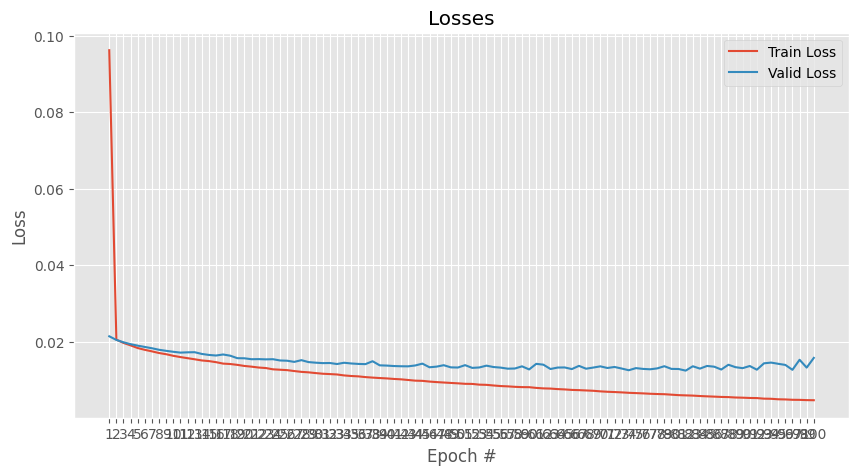

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
epoch_ticks = range(1, epochs + 1)
plt.plot(epoch_ticks, train_loss)
plt.plot(epoch_ticks, valid_loss)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

# Predict on sample data

In [13]:
# Predict on sample data
# Read data
test = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in pd.read_json('test_data.json', lines=True)['text']]
# Encoding
x_test = torch.from_numpy(Cvec.transform(test).todense()).float()
# Predict
x_pred = [int(i) for i in (bow_model(x_test)>0.5).float()]
# Create DF
df = pd.DataFrame([[i,j] for i,j in enumerate(x_pred)], columns=['id', 'class'])
# Save file
df.to_csv('predictions.csv', index=False)